In [ ]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [9]:
from collections import Counter

In [7]:
import importlib

In [9]:
import monroe_data

In [45]:
importlib.reload(Vocab)

<module 'Vocab' from '/Users/benjaminnewman/Documents/Stanford/Freshman_2017-2018/WINTER/LINGUIST130A/linguist-130a-final-proj/Vocab.py'>

In [28]:
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import Vocab

In [6]:
monroe_data = MonroeData("filteredCorpus.csv", entries_filename="monroe_speaker_data.pkl")

300) Game: 7555-2 Round: 3
purple


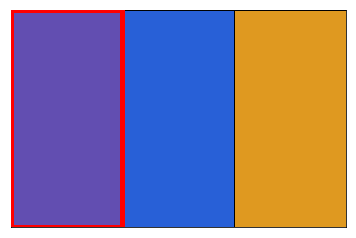

In [8]:
monroe_data.display_game(300)

In [50]:
# first, deal with the vocab

class Vocab:
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.word_count = Counter()
        self.size = 0
        
    def add_sentence(self, sentence):
        for word in sentence:
            word = word.lower()
            if not word in self.word2idx:
                self.word2idx[word] = self.size
                self.idx2word[self.size] = word
                self.size += 1
            self.word_count[word] += 1
        
            
    def __len__(self):
        return self.size

In [40]:
word_counter = Counter()
for de in monroe_data:
    for word in de.tokens:
        word_counter[word.lower()] += 1

In [225]:
word_counter == vocab.word_count

False

In [228]:
def replace_unks(sentence, word_counts):
    replace_sentence = []
    for word in sentence:
        word = word.lower()
        if word_counts[word] == 1:
            replace_sentence.append('<unk>')
        else:
            replace_sentence.append(word)
    replace_sentence.append('<eos>')
    return replace_sentence

In [229]:
processed_captions = []
for de in monroe_data:
    processed_captions.append(replace_unks(de.tokens, word_counter))

In [231]:
vocab = Vocab()
for caption in processed_captions:
    vocab.add_sentence(caption)

Quick notes on color vocab:
1. it's very small. like super small. We are trying to learn a relatively small thing though so maybe that's ok
2. slashes and dashes got included when maybe they shouldn't have. Breaking them up might ruin some real compositionality though
3. there are a good number of typos
4. More than half of the words appear once--including unks drastically limits the size of the vocab (dropping words that appear once means we have 123250/124962 = 98% of the dataset in tact. They do this in the paper, so we should probably follow. This does mean that we are going to be missing out on some interesting colors (like "pistachio") but will probably get some more meaningful relationships

In [61]:
torch.__version__

'1.0.0'

In [1]:
import torch
import torch.nn as nn
import numpy as np


In [3]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

In [29]:
%%time
#import training data: don't do any filtering because it's already filtered
monroe_data_train = MonroeData("train_corpus.csv", single_speaker=False)
monroe_data_dev = MonroeData("dev_corpus.csv", single_speaker=False)

CPU times: user 194 ms, sys: 25.4 ms, total: 220 ms
Wall time: 223 ms


In [30]:
%%time
# create data entries
for _ in monroe_data_train.read_data():
    pass
for _ in monroe_data_dev.read_data():
    pass

CPU times: user 1min 55s, sys: 789 ms, total: 1min 56s
Wall time: 1min 57s


In [32]:
# monroe_data_train.save_entries("train_entries.pkl")
# monroe_data_dev.save_entries("dev_entries.pkl")

In [46]:
# create vocab with training data
vocab, raw_wc, processed_captions = Vocab.init_vocab([ent.tokens for ent in monroe_data_train.entries])

In [47]:
processed_captions[:10]

[['purple', '<eos>'],
 ['lime', '<eos>'],
 ['mud', 'brown', '<eos>'],
 ['mud', 'brown', '<eos>'],
 ['grey', '<eos>'],
 ['purple', '<eos>'],
 ['blue', '<eos>'],
 ['<unk>',
  '.',
  'i',
  'think',
  'they',
  "'re",
  'both',
  'a',
  'bit',
  'neon',
  'the',
  'greyish',
  'one',
  'that',
  "'s",
  'not',
  'the',
  'browner',
  'one',
  '<eos>'],
 ['brown', '<eos>'],
 ['greyest', 'one', '<eos>']]

In [74]:
processed_captions_dev = []
for ent in monroe_data_dev.entries:
    processed_captions_dev.append(vocab.replace_unks(ent.tokens, raw_wc))

In [75]:
processed_captions_dev[:5]

[['darkest', 'shade', 'of', 'green', ',', 'forest', 'green', '<eos>'],
 ['one',
  'of',
  'the',
  'brown',
  'ones',
  ',',
  'the',
  'lighter',
  'shaded',
  'one',
  '<eos>'],
 ['camo', 'green', '<eos>'],
 ['brown', '<eos>'],
 ['green', '<eos>']]

In [49]:
# data preprocessing
def sentence_to_indexes(sentence, vocab):
    return [vocab.get_idx_from_word(word) for word in sentence]

def sentence_to_tensor(sentence, vocab):
    # sentence already marked with <eos>
    indexes = sentence_to_indexes(sentence, vocab)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


# colors too
def color_phi_id(color_list, space):
    """
    Function for turning a list of colors in the given space
    (with normalization marked by "_norm") into a feature function.
    
    This is just the identity feature function, so it's kind of boring,
    but we can imagine doing more complext things too (like fourier
    transform). We pass space as well in case you want to do different
    operations based on the space or only have a feature function work
    for HSL for example
    
    ex:
    color_list = [256, 0, 0] space = 'rgb'
    color_list = [1, 0, 0] space = 'rgb_norm'
    """
    return color_list


def colors_to_color_lists(colors, space, normalized):
    # non-standard, but use the space as the variable name
    # to access the color attribute directly
    class_var_name = space
    if normalized:
        class_var_name = "{}_norm".format(class_var_name)
    return [color.__dict__[class_var_name] for color in colors], class_var_name

def colors_to_tensor(colors, space="rgb", normalized=True, phi=color_phi_id):
    """
    Convert colors to tensors where the vectors are the given by applying
    the feature function phi -> phi(colors)
    
    returns all colors as |phi| x |phi| matrix
    """
    color_lists, space = colors_to_color_lists(colors, space, normalized) 
    color_lists = [phi(color_list, space) for color_list in color_lists]
    target = color_lists[0] # target is always first color
    color_tensor = torch.tensor(color_lists, dtype=torch.float) # to get column vectors
    return color_tensor
    
    

In [83]:
monroe_data_train.entries[0].colors


[hsl: [249, 25, 50], rgb [106, 96, 160],
 hsl: [129, 66, 50], rgb [44, 212, 69],
 hsl: [54, 53, 50], rgb [196, 182, 60]]

In [85]:
colors_to_tensor(monroe_data_train.entries[0].colors, normalized=False)[0]

tensor([106.,  96., 160.])

In [211]:
# ok, now let's define the model

class CaptionEncoder(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_dim):
        """
        embed_dim = hidden_dim = 100
        
        All the options can be found here: https://github.com/futurulus/colors-in-context/blob/master/models/l0.config.json
        """
        super(CaptionEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        
        # should initialize bias to 0: https://github.com/futurulus/colors-in-context/blob/2e7b830668cd039830154e7e8f211c6d4415d30f/listener.py#L383
        # he also DOESN'T use dropout for the base listener
        # also non-linearity is "leaky_rectify"
        # also LSTM is bidirectional (https://github.com/futurulus/colors-in-context/blob/2e7b830668cd039830154e7e8f211c6d4415d30f/listener.py#L713)
        # also, looks like tokenizer is the "ending" tokenizer, so it detaches endings from the vocab items
        self.lstm = nn.LSTM(embed_dim, hidden_dim)
        #self.gru = nn.GRU(embed_dim, hidden_dim)
        
        #self.color_embed = nn.Linear(color_in_dim, color_dim)
        self.mean = nn.Linear(hidden_dim, color_dim)
        # covariance matrix is square, so we initialize it with color_dim^2 dimensions
        # we also initialize the bias to be the identity
        covar_dim = color_dim*color_dim
        self.covariance = nn.Linear(hidden_dim, covar_dim)
        self.covariance.bias.data = torch.tensor(np.eye(color_dim), dtype=torch.float).flatten()
        self.logsoftmax = nn.LogSoftmax(dim=0)

        self.color_dim = color_dim
        self.hidden_dim = hidden_dim
        
    def forward(self, caption, states, colors):
        embeddings = self.embed(caption)
        output, hn = self.gru(embeddings, states)
        
        # we only care about last output
        output = output[-1].view(1, -1)
        
        output_mean = self.mean(output)[0]
        output_covariance = self.covariance(output)[0]
        covar_matrix = output_covariance.reshape(-1, self.color_dim) # make it a square matrix again
        
        
#         print(output_mean, output_mean.type())
#         print(output_covariance, output_mean.type())
#         print(colors.type())
        
        # reshape covariance vector to covariance matrix
        # upper traingular + lower triangular - diagonal
#         covar_matrix = torch.zeros(self.color_dim, self.color_dim)
#         unit_matrix = torch.ones(self.color_dim, self.color_dim)
#         id_matrix = torch.eye(self.color_dim)
#         covar_matrix[torch.triu(unit_matrix).transpose(0,1) == 1] += output_covariance # lower triangular
#         covar_matrix_diag = torch.diag(covar_matrix)
#         covar_matrix[torch.triu(unit_matrix) == 1] += output_covariance # upper triangular
#         covar_matrix -= id_matrix * covar_matrix_diag # diagonal

        # now compute color embeddings:
        #colors = self.color_embed(colors)
        
        # now compute score: -(f-mu)^T Sigma (f-mu)
        output_mean = output_mean.repeat(3,1)
        diff_from_mean = colors - output_mean
        scores = torch.matmul(diff_from_mean, covar_matrix)
        scores = torch.matmul(scores, diff_from_mean.transpose(0,1))
        scores = -torch.diag(scores)
        distribution = self.logsoftmax(scores)
        return distribution, output_mean, covar_matrix
    
    def init_hidden_and_context(self):
        return torch.zeros(1, 1, self.hidden_dim)
        #return (torch.zeros(1, 1, self.hidden_dim),
        #        torch.zeros(1, 1, self.hidden_dim))
        
        
    
        

In [242]:
embed_dim = 100
hidden_dim = 100
color_dim = 3
color_in_dim = 3

encoder = CaptionEncoder(embed_dim, hidden_dim, vocab.size, color_in_dim, color_dim)

Now try and train the thing

In [243]:
def train(caption_tensor, color_tensor, encoder, encoder_optimizer, criterion, target):
    encoder_states = encoder.init_hidden_and_context()
    
    input_length = caption_tensor.size(0)
    #print(input_length)
    
    encoder_optimizer.zero_grad()
    
    loss = 0
    
    encoder_output, _, _ = encoder(caption_tensor, encoder_states, color_tensor.transpose(0, 1))
    #print(encoder_output)
    
    encoder_output = encoder_output.view(1, -1)
    
    loss += criterion(encoder_output, target)
    #print(loss)
    loss.backward()
    encoder_optimizer.step()
    
    return loss
        

In [244]:
result = train(torch_test_caption, tensor_test_color, encoder, optimizer, criterion, torch.tensor([0]))

In [245]:
result

tensor(1.0313, grad_fn=<AddBackward0>)

In [497]:
#import pickle as pkl

In [61]:
train_pairs = []
for caption, de in zip(processed_captions, monroe_data_train.entries):
    colors = de.colors
    caption_tensor = sentence_to_tensor(caption, vocab)
    color_tensor = colors_to_tensor(colors)
    # shuffle color order
    permutation = torch.randperm(color_tensor.size(0))
    target = torch.argmin(permutation).view(-1) # target always started at 0
    color_tensor = color_tensor[permutation]
    train_pairs.append((caption_tensor, color_tensor, target))
    
# np.random.shuffle(pairs)

In [67]:
train_pairs[0]

(tensor([[0],
         [1]]), tensor([[0.1719, 0.8281, 0.2695],
         [0.4141, 0.3750, 0.6250],
         [0.7656, 0.7109, 0.2344]]), tensor([1]))

In [175]:
w = torch.empty(3, 3)

In [190]:
lin  = nn.Linear(9, 9)

In [191]:
lin

Linear(in_features=9, out_features=9, bias=True)

In [179]:
torch.nn.init.eye_(w)

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

In [185]:
tensor_id = torch.tensor(np.eye(3))

In [187]:
tensor_id.flatten()

tensor([1., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=torch.float64)

In [192]:
lin.bias.data = tensor_id.flatten()# fill_(torch.tensor(np.eye(3)))

In [193]:
lin.bias.data

tensor([1., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=torch.float64)

In [195]:
lin.weight.data

tensor([[-0.2227,  0.1028,  0.0579,  0.3286,  0.0540, -0.0983, -0.1331,  0.2266,
          0.2292],
        [ 0.0234, -0.1065, -0.1252,  0.1065, -0.3300, -0.0350, -0.1011, -0.1652,
         -0.1538],
        [-0.2696, -0.2985, -0.2578, -0.3050, -0.0802,  0.1878, -0.3049,  0.2819,
          0.2326],
        [-0.2428, -0.1332, -0.0406,  0.2954,  0.0895, -0.0473, -0.0726,  0.2839,
          0.1849],
        [ 0.0373,  0.3059,  0.0320, -0.0081, -0.3014, -0.2968,  0.2080,  0.2960,
          0.0510],
        [ 0.1232, -0.0840,  0.0054, -0.2803, -0.1987, -0.0792,  0.0808, -0.3242,
          0.1882],
        [-0.3195,  0.0993, -0.2760, -0.2081,  0.3054,  0.2381,  0.0121, -0.1306,
         -0.0337],
        [ 0.1156,  0.2742, -0.0320,  0.0465,  0.0492,  0.2269,  0.2297,  0.0608,
          0.0067],
        [-0.1766,  0.0757,  0.2557, -0.2529,  0.1153, -0.0755,  0.3323, -0.1317,
         -0.1950]])

In [196]:
tensor_id.reshape(-1, 3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)

In [76]:
dev_pairs = []
for caption, de in zip(processed_captions_dev, monroe_data_dev.entries):
    colors = de.colors
    caption_tensor = sentence_to_tensor(caption, vocab)
    color_tensor = colors_to_tensor(colors)
    # shuffle color order
    permutation = torch.randperm(color_tensor.size(0))
    target = torch.argmin(permutation).view(-1) # target always started at 0
    color_tensor = color_tensor[permutation]
    dev_pairs.append((caption_tensor, color_tensor, target))

In [501]:
# TODO: actually randomize the ordering and selection of num_train, num_test

# num_train = 1523108
# num_test = 544768
# pairs_train = pairs[:num_train]
# pairs_test = pairs[-num_test:]

# with open("train_pairs.pkl", "wb") as train_file:
#     pkl.dump(pairs_train, train_file)
    
# with open("test_pairs.pkl", "wb") as test_file:
#     pkl.dump(pairs_test, test_file)




In [57]:
import time
import math

In [58]:
# from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
num_epochs = 30
lr = 0.2

optimizer = torch.optim.Adadelta(lr=lr,params=encoder.parameters())
criterion = nn.NLLLoss()

start_time = time.time()
store_losses_every = 100
print_losses_every = 1000
stored_losses = []
for epoch in range(num_epochs):
    print("---EPOCH {}---".format(epoch))
    stored_loss_total = 0
    print_loss_total = 0

    for i, pair in enumerate(train_pairs):
        caption, colors, target = pair
        # print(target)
        
        loss = train(caption, colors, encoder, optimizer, criterion, target)
        stored_loss_total += loss.item()
        print_loss_total += loss.item()
        
        if i % print_losses_every == 0:
            print_loss_avg = print_loss_total / print_losses_every
            print("{} ({}:{} {:.2f}%) {:.4f}".format(asMinutes(time.time() - start_time),
                                              epoch, i, i/len(train_pairs)*100,
                                              print_loss_avg))
            print_loss_total = 0
        #break    
        if i % store_losses_every == 0:
            stored_loss_avg = stored_loss_total / store_losses_every
            stored_losses.append(stored_loss_avg)
            stored_loss_total = 0
                

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0014
0m 6s (0:1000 6.38%) 1.0980
0m 12s (0:2000 12.77%) 1.0661
0m 18s (0:3000 19.15%) 1.0902
0m 23s (0:4000 25.53%) 1.0600
0m 30s (0:5000 31.92%) 1.0638
0m 36s (0:6000 38.30%) 1.0573
0m 43s (0:7000 44.69%) 1.0610
0m 50s (0:8000 51.07%) 1.0645
0m 57s (0:9000 57.45%) 1.0573
1m 3s (0:10000 63.84%) 1.0560
1m 10s (0:11000 70.22%) 1.0500
1m 17s (0:12000 76.60%) 1.0599
1m 24s (0:13000 82.99%) 1.0757
1m 30s (0:14000 89.37%) 1.0479
1m 37s (0:15000 95.75%) 1.0729
---EPOCH 1---
1m 41s (1:0 0.00%) 0.0009
1m 48s (1:1000 6.38%) 1.0375
1m 54s (1:2000 12.77%) 1.0407
2m 1s (1:3000 19.15%) 1.0788
2m 7s (1:4000 25.53%) 1.0401
2m 13s (1:5000 31.92%) 1.0470
2m 20s (1:6000 38.30%) 1.0409
2m 26s (1:7000 44.69%) 1.0446
2m 33s (1:8000 51.07%) 1.0493
2m 39s (1:9000 57.45%) 1.0368
2m 46s (1:10000 63.84%) 1.0385
2m 52s (1:11000 70.22%) 1.0374
2m 59s (1:12000 76.60%) 1.0551
3m 6s (1:13000 82.99%) 1.0684
3m 12s (1:14000 89.37%) 1.0330
3m 18s (1:15000 95.75%) 1.0649
---EPOCH 2---
3m

In [157]:
import matplotlib.pyplot as plt

In [159]:
%matplotlib inline

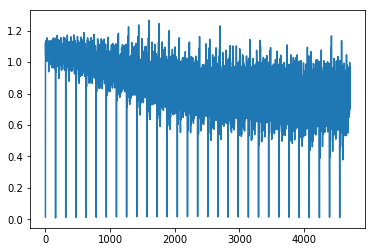

In [218]:
plt.plot(stored_losses)

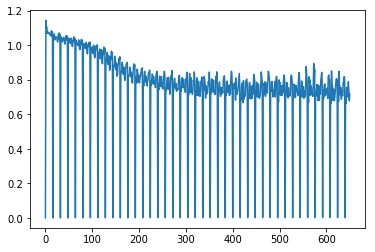

In [171]:
plt.plot(stored_losses)

In [ ]:
def evaluate(encoder, pair):
    with torch.no_grad():
        caption_tensor, color_tensor, target = pair
        encoder_states = encoder.init_hidden_and_context()
        encoder_output, _, _ = encoder(caption_tensor, encoder_states, color_tensor.transpose(0, 1))
    
        encoder_output = encoder_output.view(1, -1)
        if torch.argmax(encoder_output).item() == target.item():
            return 1, encoder_output
        else:
            return 0, encoder_output

    
total_correct = 0
for pair in dev_pairs:
    correct, _ = evaluate(encoder, pair) 
    total_correct += correct


    

In [163]:
print(total_correct/len(train_pairs))

0.6831790616022981


In [155]:
print(total_correct/len(train_pairs))

0.6610916054899457


In [ ]:
# no color embedding, bi-lstm, all speaker utterances, 30 epochs, completely learned covar
print(total_correct/len(dev_pairs))

In [220]:
# no color embedding, gru, all speaker utterances, 30 epochs, completely learned covar
print(total_correct/len(dev_pairs))

0.4197192086790045


In [174]:
# color embedding, gru, all speaker utterances, 30 epochs
print(total_correct/len(dev_pairs))

0.41895341416719845


In [165]:
# color embedding, lstm, all speaker utterances, 40 epochs
print(total_correct/len(dev_pairs))

0.4532865347798341


In [153]:
# color embedding, lstm, all speaker utterances, 25 epochs
print(total_correct/len(dev_pairs))

0.4337587747287811


In [79]:
# just rgb, lstm, all speaker utterances, 40 epochs
print(total_correct/len(dev_pairs))

0.5238034460753032


In [570]:
# just rgb, lstm, 5 epochs, final speaker utterances (different training data)
print(total_correct/len(pairs_test))

0.5557517981018854


In [232]:
dev_pairs[2]

(tensor([[750],
         [ 36],
         [  1]]), tensor([[0.4180, 0.6055, 0.3945],
         [0.7031, 0.2969, 0.3359],
         [0.3281, 0.6719, 0.4727]]), tensor([0]))

In [230]:
evaluate(encoder, dev_pairs[2])

(0, tensor([[-2.4830, -0.6985, -0.8694]]))

2) Game: 1124-1 Round: 19
Camo green


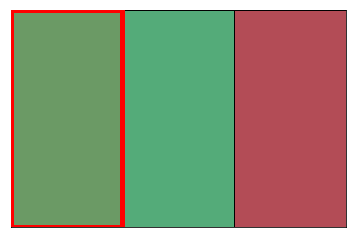

In [231]:
monroe_data_dev.display_game(2)

In [227]:
monroe_data_dev[0].colors[0].rgb_norm

[0.24609375, 0.796875, 0.203125]

In [541]:
print(total_correct)

0


In [549]:
[vocab.idx2word[idx.item()] for idx in pairs_test[60][0]]

['green-ish', 'yellow', '<eos>']

In [550]:
for i in range(len(monroe_data.entries)):
    if monroe_data[i].tokens == ['green-ish', 'yellow']:
        print(i)

10291


In [560]:
target_test = pairs_test[60][2]

In [562]:
target_test.item()

0

In [559]:
pairs_test[60]

(tensor([[757],
         [ 40],
         [  4]]), tensor([[0.3438, 0.7891, 0.2109],
         [0.3281, 0.6719, 0.3477],
         [0.2656, 0.7344, 0.3516]]), tensor([0]))

In [563]:
_, res_dist = evaluate(encoder, pairs_test[60])

In [566]:
res_dist

tensor([[-0.7818, -0.8401, -2.2002]])

In [567]:
torch.argmax(res_dist)

tensor(0)

10291) Game: 9975-6 Round: 37
green-ish yellow


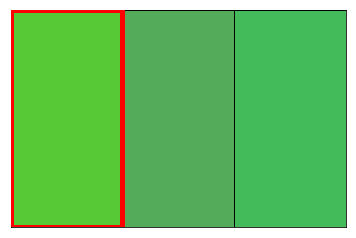

In [551]:
monroe_data.display_game(10291)

In [433]:
tensor_test_color.type()

'torch.FloatTensor'

In [457]:
m = nn.LogSoftmax(dim=0)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)
output.backward()

In [460]:
m(input)

tensor([[-0.8423, -2.0615, -1.6769, -0.8026, -2.5770],
        [-0.9728, -2.9595, -0.8049, -1.2059, -2.4637],
        [-1.6542, -0.1974, -1.0053, -1.3767, -0.1757]],
       grad_fn=<LogSoftmaxBackward>)

In [461]:
loss(m(input), target)

tensor(1.0700, grad_fn=<NllLossBackward>)

In [239]:
np.argmax([len(cap) for cap in processed_captions])

15715

In [51]:
tensor_test_color = colors_to_tensor(monroe_data_train[0].colors)

In [473]:
tensor_test_color

tensor([[0.0938, 0.2852, 0.9062],
        [0.6875, 0.0664, 0.9336],
        [0.1641, 0.0391, 0.9609]])

In [481]:
tensor_test_color.size(0)

3

In [486]:
rand_tensor = torch.randperm(tensor_test_color.size(0))

In [487]:
rand_tensor

tensor([2, 0, 1])

In [488]:
tensor_test_color[rand_tensor]

tensor([[0.1641, 0.0391, 0.9609],
        [0.0938, 0.2852, 0.9062],
        [0.6875, 0.0664, 0.9336]])

In [491]:
torch.argmin(rand_tensor).view(-1)

tensor([1])

In [476]:
a = [c.rgb_norm for c in monroe_data[0].colors]

In [477]:
a

[[0.09375, 0.28515625, 0.90625],
 [0.6875, 0.06640625, 0.93359375],
 [0.1640625, 0.0390625, 0.9609375]]

In [478]:
random.shuffle(a)

In [479]:
a

[[0.6875, 0.06640625, 0.93359375],
 [0.09375, 0.28515625, 0.90625],
 [0.1640625, 0.0390625, 0.9609375]]

In [50]:
torch_test_caption = sentence_to_tensor(processed_captions[0], vocab)

In [307]:
processed_captions[0]

['the', 'darker', 'blue', 'one', '<eos>']

In [304]:
vocab.word2idx['<eos>']

4

In [308]:
torch_test_caption

tensor([[0],
        [1],
        [2],
        [3],
        [4]])

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    states = (torch.zeros)

In [107]:
mu = torch.tensor([0.25, 0.5, 0.75, 1, 1.25])

In [115]:
mu

tensor([200.,  29.,  96.], dtype=torch.float64)

In [82]:
rand_mat = np.random.rand(3, 3)/10

In [83]:
rand_mat

array([[0.08696282, 0.06498258, 0.04321573],
       [0.04224026, 0.05789655, 0.06327257],
       [0.00498122, 0.04183398, 0.02791706]])

In [85]:
sigma = torch.tensor(np.eye(3) + rand_mat)

In [98]:
sigma

tensor([[1.0870, 0.0650, 0.0432],
        [0.0422, 1.0579, 0.0633],
        [0.0050, 0.0418, 1.0279]], dtype=torch.float64)

In [184]:
colors = torch.tensor(np.eye(3)*1.)

In [104]:
colors_random = torch.rand(3, 5)

In [105]:
colors_random

tensor([[0.9790, 0.6466, 0.5906, 0.6233, 0.0650],
        [0.3828, 0.6325, 0.8088, 0.7705, 0.6073],
        [0.3502, 0.5642, 0.6234, 0.9709, 0.1917]])

In [108]:
mus = mu.repeat(3,1)

In [114]:
mus

tensor([[0.2500, 0.5000, 0.7500, 1.0000, 1.2500],
        [0.2500, 0.5000, 0.7500, 1.0000, 1.2500],
        [0.2500, 0.5000, 0.7500, 1.0000, 1.2500]])

In [109]:
diff = colors_random - mus

In [110]:
diff

tensor([[ 0.7290,  0.1466, -0.1594, -0.3767, -1.1850],
        [ 0.1328,  0.1325,  0.0588, -0.2295, -0.6427],
        [ 0.1002,  0.0642, -0.1266, -0.0291, -1.0583]])

In [122]:
id_covar = torch.tensor(np.eye(5), dtype=torch.float)

In [199]:
x =id_covar.reshape(-1)

In [201]:
id_covar

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [134]:
torch.matmul(diff, id_covar)

tensor([[ 0.7290,  0.1466, -0.1594, -0.3767, -1.1850],
        [ 0.1328,  0.1325,  0.0588, -0.2295, -0.6427],
        [ 0.1002,  0.0642, -0.1266, -0.0291, -1.0583]])

In [136]:
torch.matmul(torch.matmul(diff, id_covar), diff.transpose(0,1))

tensor([[2.1245, 0.9550, 1.3677],
        [0.9550, 0.5044, 0.7013],
        [1.3677, 0.7013, 1.1511]])

In [135]:
torch.matmul(torch.matmul(diff, id_covar), diff.t())

tensor([[2.1245, 0.9550, 1.3677],
        [0.9550, 0.5044, 0.7013],
        [1.3677, 0.7013, 1.1511]])

In [133]:
torch.matmul(id_covar, diff.t())

tensor([[ 0.7290,  0.1328,  0.1002],
        [ 0.1466,  0.1325,  0.0642],
        [-0.1594,  0.0588, -0.1266],
        [-0.3767, -0.2295, -0.0291],
        [-1.1850, -0.6427, -1.0583]])

In [131]:
torch.matmul(diff, torch.matmul(id_covar, diff.t()))

tensor([[2.1245, 0.9550, 1.3677],
        [0.9550, 0.5044, 0.7013],
        [1.3677, 0.7013, 1.1511]])

In [153]:
torch.diag(mus)

tensor([200.,  29.,  96.], dtype=torch.float64)

In [148]:
torch.tril(sigma, 2)

tensor([[1.0870, 0.0650, 0.0432],
        [0.0422, 1.0579, 0.0633],
        [0.0050, 0.0418, 1.0279]], dtype=torch.float64)

In [186]:
diff

tensor([[ 0.5000, -0.5000, -0.5000],
        [-0.5000,  0.5000, -0.5000],
        [-0.5000, -0.5000,  0.5000]], dtype=torch.float64)

In [187]:
scores = torch.diag(-torch.matmul(diff.transpose(0,1), torch.matmul(sigma, diff)))

In [88]:
colors

tensor([[256.,   0.,   0.],
        [  0., 256.,   0.],
        [  0.,   0., 256.]], dtype=torch.float64)

In [125]:
torch.matmul(sigma, mu)

tensor([223.4258,  45.2012, 100.8895], dtype=torch.float64)

In [127]:
np.dot(mu.numpy().T, np.dot(sigma.numpy(), mu.numpy()))

55681.37797980321

In [163]:
soft = nn.Softmax(dim=0)

In [175]:
test = torch.tensor([1., 2., 3.])

In [188]:
scores

tensor([-0.7806, -0.7522, -0.7817], dtype=torch.float64)

In [189]:
soft(scores)

tensor([0.3303, 0.3398, 0.3299], dtype=torch.float64)

In [177]:
lsoft = nn.LogSoftmax(dim=0)

In [190]:
lsoft(scores)

tensor([-1.1078, -1.0794, -1.1089], dtype=torch.float64)

In [ ]:
def score(colors, mu, sigma):
    

In [199]:
vec = torch.tensor([1., 2., 3., 4., 5., 6.])

In [213]:
mat = torch.zeros(3, 3)

In [214]:
mat[torch.triu(torch.ones(3, 3)).transpose(0,1) == 1] += vec

In [215]:
diagonal = torch.diag(mat)

In [216]:
diagonal

tensor([1., 3., 6.])

In [217]:
mat[torch.triu(torch.ones(3, 3)) == 1] += vec

In [219]:
mat -= torch.eye(3) * diagonal

In [220]:
mat

tensor([[1., 2., 3.],
        [2., 4., 5.],
        [4., 5., 6.]])

In [33]:
sum(vocab.word_count[w] for w in vocab.word_count)

124962

In [34]:
123250/124962

0.9862998351498856

In [ ]:
super(CaptionEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim)
        
        self.color_embed = nn.Linear(color_in_dim, color_dim)

In [ ]:
class ColorEncoder(nn.Module):
    
    def __init__(self, color_in_dim, color_dim):
        super(ColorEncoder, self).__init__()
        self.color_embed = nn.Linear(color_in_dim, color_dim)
        self.color_lstm = nn.LSTM(color_dim, hidden_dim)

    def forward(self, colors, color_states):
        colors_embed = self.color_embed(colors)
        color_outpu, (hn, cn) = self.color_lstm(colors_embed, color_states)
        # target is last - return context representation
        return cn

class Speaker(nn.Module):
    
    def __init__(self, color_in_dim, color_dim, vocab_size, embed_dim, speaker_hidden_dim):
        super(Speaker, self).__init__()
        
        self.color_encoder = ColorEncoder(color_in_dim, color_dim)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.speaker_lstm = nn.LSTM(embed_dim + color_dim, speaker_hidden_dim)
        
    def forward(self, colors, captions, color_states, caption_states):
        
        color_rep = self.color_encoder(colors, color_states)
        
        
        
        

Let's try this again...this time more similar to how Will did it in his actual code:

In [241]:
# ok, now let's define the model

class CaptionEncoder(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_dim):
        """
        embed_dim = hidden_dim = 100
        
        All the options can be found here: https://github.com/futurulus/colors-in-context/blob/master/models/l0.config.json
        """
        super(CaptionEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        
        # should initialize bias to 0: https://github.com/futurulus/colors-in-context/blob/2e7b830668cd039830154e7e8f211c6d4415d30f/listener.py#L383
        
        # √ he also DOESN'T use dropout for the base listener 
        
        # also non-linearity is "leaky_rectify" - I can't implement this without rewriting lstm :(, so I'm just going
        # to hope this isn't a problem
        
        # √ also LSTM is bidirectional (https://github.com/futurulus/colors-in-context/blob/2e7b830668cd039830154e7e8f211c6d4415d30f/listener.py#L713)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True)
        
        self.mean = nn.Linear(2*hidden_dim, color_dim)
        # covariance matrix is square, so we initialize it with color_dim^2 dimensions
        # we also initialize the bias to be the identity
        covar_dim = color_dim*color_dim
        self.covariance = nn.Linear(2*hidden_dim, covar_dim)
        self.covariance.bias.data = torch.tensor(np.eye(color_dim), dtype=torch.float).flatten()
        self.logsoftmax = nn.LogSoftmax(dim=0)

        self.color_dim = color_dim
        self.hidden_dim = hidden_dim
        
    def forward(self, caption, states, colors):
        embeddings = self.embed(caption)
        output, (hn, cn) = self.lstm(embeddings, states)
        
        # we only care about last output
        output = output[-1].view(1, -1)
        
        output_mean = self.mean(output)[0]
        output_covariance = self.covariance(output)[0]
        covar_matrix = output_covariance.reshape(-1, self.color_dim) # make it a square matrix again
        
        
        # now compute score: -(f-mu)^T Sigma (f-mu)
        colors = colors.transpose(0, 1)
        output_mean = output_mean.repeat(3,1)
        diff_from_mean = colors - output_mean
        scores = torch.matmul(diff_from_mean, covar_matrix)
        scores = torch.matmul(scores, diff_from_mean.transpose(0,1))
        scores = -torch.diag(scores)
        distribution = self.logsoftmax(scores)
        return distribution, output_mean, covar_matrix
    
    def init_hidden_and_context(self):
        # first 2 for each direction
        return (torch.zeros(2, 1, self.hidden_dim),
                torch.zeros(2, 1, self.hidden_dim))
        
               